# House Price analysis pipeline

In [11]:
from sklearn.datasets import fetch_openml
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multicomp import MultiComparison
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

In [12]:
X, y = fetch_openml("house_prices", version=1, as_frame=True, return_X_y=True)
df = pd.concat([X, y], axis=1)
print(df.shape)
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1.0,60.0,RL,65.0,8450.0,Pave,None,Reg,Lvl,AllPub,...,0.0,None,None,None,0.0,2.0,2008.0,WD,Normal,208500.0
1,2.0,20.0,RL,80.0,9600.0,Pave,None,Reg,Lvl,AllPub,...,0.0,None,None,None,0.0,5.0,2007.0,WD,Normal,181500.0
2,3.0,60.0,RL,68.0,11250.0,Pave,None,IR1,Lvl,AllPub,...,0.0,None,None,None,0.0,9.0,2008.0,WD,Normal,223500.0
3,4.0,70.0,RL,60.0,9550.0,Pave,None,IR1,Lvl,AllPub,...,0.0,None,None,None,0.0,2.0,2006.0,WD,Abnorml,140000.0
4,5.0,60.0,RL,84.0,14260.0,Pave,None,IR1,Lvl,AllPub,...,0.0,None,None,None,0.0,12.0,2008.0,WD,Normal,250000.0


<AxesSubplot:>

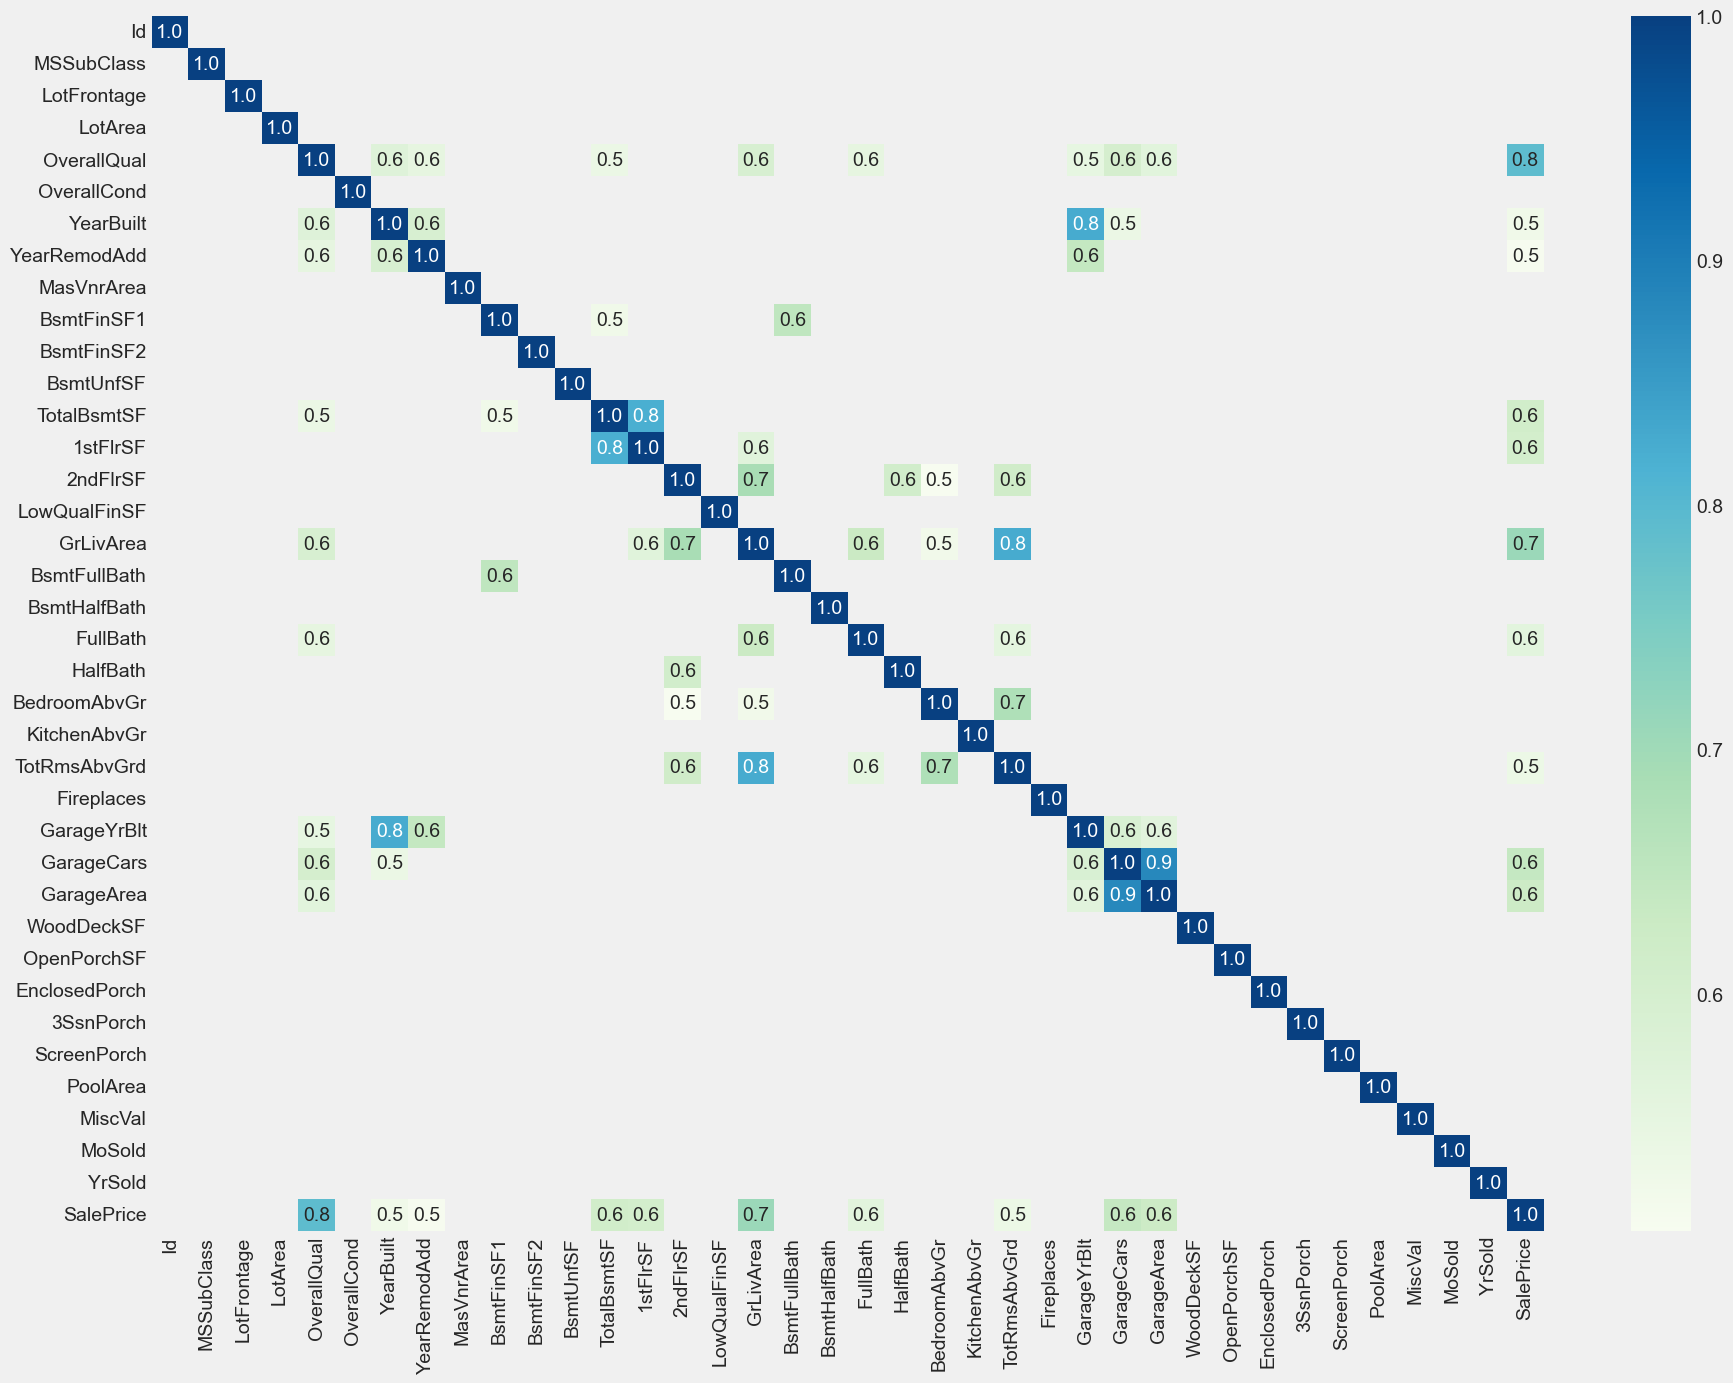

In [13]:
corr_mat = df.corr(numeric_only=True)
high_corr_mat = corr_mat[abs(corr_mat) >= 0.5]

# Plot correlation heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(high_corr_mat, annot=True, fmt='.1f', cmap='GnBu')

## Estimating the Coefficients
### Univariate: y = α + βx + ε

                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -9.621e+04   5756.407    -16.713      0.000   -1.07e+05   -8.49e+04
OverallQual  4.544e+04    920.430     49.364      0.000    4.36e+04    4.72e+04
SalePrice = -96,206.08 + 45,435.80 * OverallQual
R2: 0.625651892462118


Text(0.5, 1.0, 'SalePrice & OverallQual relationship')

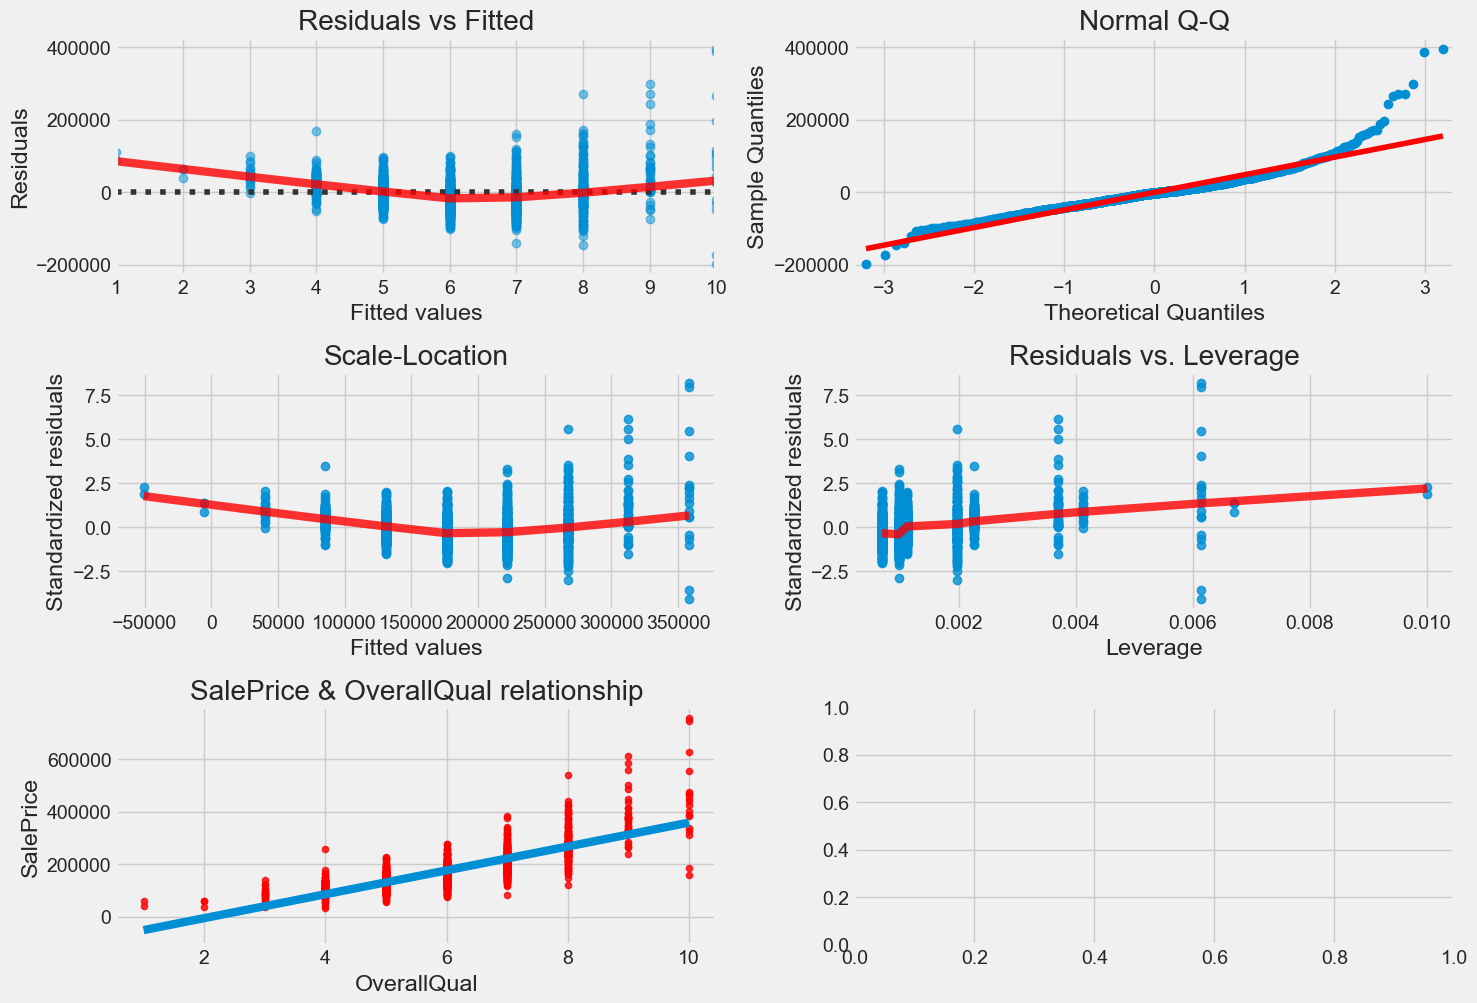

In [14]:
target = 'SalePrice'
var = 'OverallQual'

# coef
linear_model = smf.ols(f'{target} ~ {var}', data=df).fit()
print(linear_model.summary().tables[1])
print(f'{target} = {linear_model.params[0]:,.2f} + {linear_model.params[1]:,.2f} * {var}')
print(f'R2: {linear_model.rsquared}')

# plot
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes = axes.flatten()
line_kws = {'color': 'red', 'alpha': 0.8}

# 1st assumption: x & y have a linear relationship
sns.residplot(data=df, x=var, y=target, lowess=True, scatter_kws={'alpha': 0.5}, line_kws=line_kws, ax=axes[0])
axes[0].set_title('Residuals vs Fitted')
axes[0].set_xlabel('Fitted values')
axes[0].set_ylabel('Residuals')

# 2nd assumption: ε is normally distributed
sm.qqplot(linear_model.resid, line='s', ax=axes[1])
axes[1].set_title('Normal Q-Q')

# 3rd assumption: y std does not change according to x
influence = linear_model.get_influence()
y = influence.resid_studentized_internal
sns.regplot(x=linear_model.fittedvalues, y=y, scatter=True, lowess=True, line_kws=line_kws, ax=axes[2])
axes[2].set_title('Scale-Location')
axes[2].set_xlabel('Fitted values')
axes[2].set_ylabel('Standardized residuals')

# 4th assumption: yi and yi-1 are independent
x = influence.hat_matrix_diag
sns.regplot(x=x, y=y, scatter=True, lowess=True, line_kws=line_kws, ax=axes[3])
axes[3].set_title('Residuals vs. Leverage')
axes[3].set_xlabel('Leverage')
axes[3].set_ylabel('Standardized residuals')

fig.tight_layout()

# fit linear
sns.regplot(x=df[var], y=df[target], order=1, scatter_kws={'color': 'r', 's': 20}, ax=axes[4])
axes[4].set_title(f'{target} & {var} relationship')

- Slope: β = 45,435 means that when OverallQual increases in 1 points SalePrice will increase 45,435
- R2 = 62.5% means that SalePrice is explained 62.5% by OverallQual.

** Checking Linear Assumptions:
- 1st: OverallQual and SalePrice should have a linear relationship. The Residuals vs Fitted plot shows if there are any nonlinear patterns in the residuals. If this assumption holds and our data can be fit by a linear model, then we should see a relatively flat line when looking at the residuals vs fitted. Notice the bow-shaped line in red, this is an indicator that we are failing to capture some of the non-linear features of the model.
- 2nd: The distribution of ε must be normally distributed. The Normal QQ plot shows if the residuals are normally distributed. A good normal QQ plot has all of the residuals lying on or close to the red line. Looking at the graph above, there are several points that fall far away from the red line. This is indicative of the errors not being normally distributed, in fact our model suffers from “heavy tails”.
- 3rd: The Scale-Location shows if there are any relationships between standardized residuals and fitted values.
- 4th: This chart shows if there are any influential observation.

### Univariate: Category

<AxesSubplot:xlabel='GarageType', ylabel='SalePrice'>

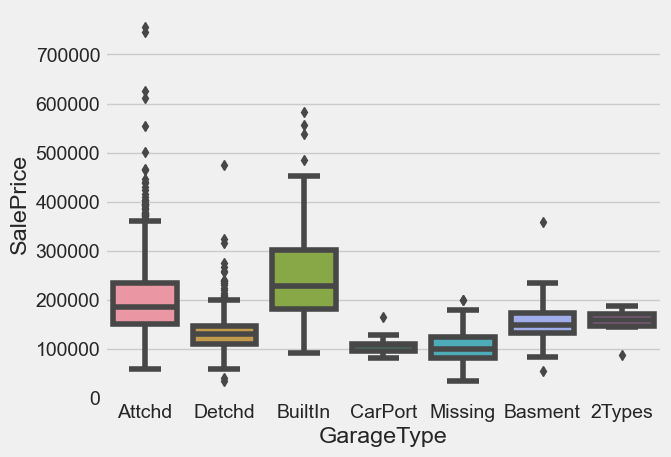

In [15]:
var = 'GarageType'
df[var].fillna('Missing', inplace=True)

sns.boxplot(data=df, x=var, y=target)

It seems that some houses have BuiltIn GarageType have the higher SalePrice than the others. To measure the difference, we run a linear model to check

In [16]:
# coef
linear_model = smf.ols(f'{target} ~ {var}', data=df).fit()
print(linear_model.summary().tables[1])
print(f'R2: {linear_model.rsquared}')

                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1.513e+05   2.82e+04      5.372      0.000     9.6e+04    2.07e+05
GarageType[T.Attchd]   5.161e+04   2.83e+04      1.826      0.068   -3819.477    1.07e+05
GarageType[T.Basment]  9287.3509   3.23e+04      0.288      0.774   -5.41e+04    7.27e+04
GarageType[T.BuiltIn]  1.035e+05   2.91e+04      3.555      0.000    4.64e+04    1.61e+05
GarageType[T.CarPort] -4.132e+04   3.64e+04     -1.137      0.256   -1.13e+05       3e+04
GarageType[T.Detchd]  -1.719e+04   2.84e+04     -0.606      0.545   -7.29e+04    3.85e+04
GarageType[T.Missing] -4.797e+04   2.92e+04     -1.644      0.100   -1.05e+05    9281.930
R2: 0.24920423050428975


Based on P < 0.05, the result shows that houses built in BuiltIn have higher SalePrice than 2Types ~ 103,500. However, the result only show the price difference between 2Types and others so we need to deep dive more to check others garage types.
Use Tukey method to compare among GarageType

In [17]:
mc = MultiComparison(df[target], df[var])
result = mc.tukeyhsd()
df_result = pd.DataFrame(data=result._results_table.data[1:], columns=result._results_table.data[0])
df_result.sort_values('p-adj')

,group1,group2,meandiff,p-adj,lower,upper,reject
10,Attchd,Missing,-99575.3724,0.0000,-123233.5860,-75917.1588,True
17,BuiltIn,Missing,-151434.4547,0.0000,-182792.8140,-120076.0954,True
16,BuiltIn,Detchd,-120660.5758,0.0000,-144712.1669,-96608.9848,True
15,BuiltIn,CarPort,-144789.6275,0.0000,-216061.3249,-73517.9302,True
11,Basment,BuiltIn,94181.0544,0.0000,42662.0363,145700.0726,True
9,Attchd,Detchd,-68801.4935,0.0000,-81245.1025,-56357.8846,True
7,Attchd,BuiltIn,51859.0823,0.0000,29077.9337,74640.2310,True
8,Attchd,CarPort,-92930.5452,0.0012,-161165.5745,-24695.5160,True
20,Detchd,Missing,-30773.8788,0.0050,-55657.7968,-5889.9609,True
2,2Types,BuiltIn,103468.4053,0.0071,17539.2009,189397.6098,True


### Univariate: Poly

### Multivariate

In [18]:
var = 'OverallQual + GarageArea'
est = sm.OLS.from_formula(f'{target} ~ {var}', df).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-9.067e+04,5400.290,-16.790,0.000,-1.01e+05,-8.01e+04
OverallQual,3.699e+04,1041.328,35.526,0.000,3.5e+04,3.9e+04
GarageArea,97.1547,6.736,14.424,0.000,83.942,110.368


In [19]:
est.summary().tables[0]

Dep. Variable:,SalePrice,R-squared:,0.672
Model:,OLS,Adj. R-squared:,0.672
Method:,Least Squares,F-statistic:,1495.
Date:,"Sat, 10 Dec 2022",Prob (F-statistic):,0.00
Time:,17:04:50,Log-Likelihood:,-17729.
No. Observations:,1460,AIC:,3.546e+04
Df Residuals:,1457,BIC:,3.548e+04
Df Model:,2,,
Covariance Type:,nonrobust,,


- The F-test tries to answer the question “Is There a Relationship Between the Response and Predictors?”
- In particular, it tests the following hypothesis:H1: is at least one coefficient different from zero? against the null hypothesis H0: β0 = β1 = … = 0. This hypothesis test is performed by computing the F-statistic: F = ((TSS - RSS) / p) / (RSS / (n - p - 1)). A rule of thumb is to reject H0 if F > 10.